# Кейс 3. Прогнозирование конверсии пользователя в первую подписку из пробного периода

**Компания:** онлайн-кинотеатр, предоставляющий доступ к библиотеке фильмов, сериалов и собственного контента по модели ежемесячной подписки.

**Продукт:** мобильное и веб-приложение, где пользователи оформляют подписку и получают доступ к контенту. Задача решается в рамках маркетингово-аналитической платформы компании, чтобы повысить удержание пользователей и снизить отток.

**Проблема продукта.** Не все пользователи покупают подписку после окончания пробного периода. Это приводит к росту расходов на привлечение новых пользователей.

### Колонки в данных:

* user_id — id пользователя;

* start_trial_date — день начала триального периода пользователя;

* source — источник появления пользователя на сервисе;

* device — устройство, с которого пользователь зарегистрировался;

* city — город, из которого пользователь зарегистрировался;

* favourite_genre — любимый жанр, указанный пользователем при регистрации;

* avg_min_watch_daily — среднее число минут просмотра в день;

* number_of_days_logged — количество дней в течение триального периода, когда пользователь логировался на сервисе;

* сhurn — купил ли пользователь подписку по окончании триального периода (0) или нет (1).

## Первичный обзор и очистка данных

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import norm

In [2]:
# Смотрим, какие данные лежат в датасете
df = pd.read_csv("videostreaming_platform.csv")
display(df.shape)
display(df.head(10))
display(df.info())
display(df.describe())
display(df.describe(include = 'object'))

(28000, 9)

,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
0,d1b6ef34-1991-452a-8c39-c83c0d5805fe,2024-02-01,St Petersburg,ios,performance,drama,2.076642,4,1
1,f1bf2396-73d8-461e-a775-9f068bd99326,2024-02-01,Other,web,seo,criminal,5.101392,1,1
2,ec9fa0be-4bd8-4fe6-910a-e9e6d4bbba28,2024-02-01,Ufa,web,performance,criminal,2.906597,1,1
3,b0195e96-af2e-4ac3-8f60-26b8d862af84,2024-02-01,Moscow,smarttv,seo,thriller,2.702388,6,0
4,a208985a-7244-4291-8d38-64c8141e27b2,2024-02-01,Ufa,web,performance,thriller,10.237305,1,1
5,8fe925f1-d767-44c2-abe2-a4beb9fd7d65,2024-02-01,Samara,web,seo,comedy,11.517933,1,1
6,172c55a4-c4f1-49d5-8378-f34c6335e932,2024-02-01,Other,web,organic,comedy,18.315863,1,1
7,d5c952de-0007-4121-96eb-c9a69a7bd3b2,2024-02-01,Moscow,web,seo,NaN,18.686651,2,0
8,a47828d4-3f59-4b97-900b-0072a4627ac2,2024-02-01,Krasnodar,web,performance,criminal,22.086605,1,1
9,cc61c271-a52b-43a0-a975-a46a555e588c,2024-02-01,Yekaterinburg,smarttv,performance,action,12.320862,6,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                28000 non-null  object 
 1   start_trial_date       28000 non-null  object 
 2   city                   27692 non-null  object 
 3   device                 28000 non-null  object 
 4   source                 28000 non-null  object 
 5   favourite_genre        20048 non-null  object 
 6   avg_min_watch_daily    28000 non-null  float64
 7   number_of_days_logged  28000 non-null  int64  
 8   churn                  28000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 1.9+ MB


None

,avg_min_watch_daily,number_of_days_logged,churn
count,28000.000000,28000.00000,28000.000000
mean,7.812663,1.88600,0.789286
std,7.739760,1.48293,0.407823
min,0.000181,1.00000,0.000000
25%,2.521966,1.00000,1.000000
50%,5.419012,1.00000,1.000000
75%,10.487946,2.00000,1.000000
max,80.072401,7.00000,1.000000


,user_id,start_trial_date,city,device,source,favourite_genre
count,28000,28000,27692,28000,28000,20048
unique,28000,28,9,4,3,5
top,bdde7df5-3daf-4f5e-a102-7b2453d4a932,2024-02-28,Moscow,web,performance,drama
freq,1,1103,8736,17752,14540,4928


In [3]:
# ищем NaNы

#display(df[df[['user_id']].isna().any(axis=1)])
#display(df[df[['start_trial_date']].isna().any(axis=1)])
display(df[df[['city']].isna().any(axis=1)].head(4))
#display(df[df[['device']].isna().any(axis=1)])
#display(df[df[['source']].isna().any(axis=1)])
display(df[df[['favourite_genre']].isna().any(axis=1)].head(4))
#display(df[df[['avg_min_watch_daily']].isna().any(axis=1)].head(4))
#display(df[df[['churn']].isna().any(axis=1)])

,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
83,73246199-a862-42b8-aa9c-d8b95d41ca70,2024-02-01,NaN,web,organic,criminal,4.869458,3,1
210,ade92161-a94e-4872-a999-182a3619be06,2024-02-01,NaN,web,organic,drama,7.708577,4,1
214,a08374fd-eefc-40b9-9014-78e22eb4de99,2024-02-01,NaN,smarttv,seo,action,2.997737,2,1
470,0b71eb0e-7b7d-4119-8485-6c1c8f114c58,2024-02-01,NaN,web,organic,action,5.767928,1,1


,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
7,d5c952de-0007-4121-96eb-c9a69a7bd3b2,2024-02-01,Moscow,web,seo,NaN,18.686651,2,0
10,24eab8d9-9ce7-4ef5-bd73-e4879ceeafa1,2024-02-01,Novosibirsk,ios,organic,NaN,15.276161,5,1
15,a62909c8-f6f4-470e-a608-6dab843ee270,2024-02-01,Krasnodar,web,performance,NaN,6.119652,4,1
22,19188564-f21a-4f50-a269-0fb651689391,2024-02-01,Moscow,smarttv,performance,NaN,21.378335,2,1


### Типы данных
Почти все переменные категориальные - city(9 уникальных), device(4 уникальных), source(3 уникальных), favourite_genre(5 уникальных).

Числовые - только avg_min_watch_daily и number_of_days_logged.

start_trial_date - дата, но столбец в текстовом формате. Можно получить из них номер когорты - ординальную переменную.

Таргет churn - логически булевый, фактически числовой.

### Пропущенные значения
city - около 1% значений пропущено.

favourite_genre - около 28% пропущено.

In [4]:
# сгенерируем еще одну фичу - день недели начала триала
df['start_trial_weekday'] = pd.to_datetime(df['start_trial_date']).dt.dayofweek + 1

# заполняем NaNы(а они у нас только в строковых city и favourite_genre) строковых данных значением "n/a"
df = df.fillna("n/a")

# Все категориальные переменные кодируем через one-hot encoding

encoded_dfs = []

for col in ['city', 'device', 'source', 'favourite_genre', 'start_trial_weekday']:

    encoder = OneHotEncoder(drop=None, sparse_output=False, dtype=int)
    encoded_array = encoder.fit_transform(df[[col]])
    
    encoded_df = pd.DataFrame(
        encoded_array, 
        columns=encoder.get_feature_names_out([col])
    )
    encoded_dfs.append(encoded_df)

all_encoded = pd.concat(encoded_dfs, axis=1)

df = pd.concat([df, all_encoded], axis=1).drop(
    columns=['city', 'device', 'source', 'favourite_genre','start_trial_weekday']
)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   28000 non-null  object 
 1   start_trial_date          28000 non-null  object 
 2   avg_min_watch_daily       28000 non-null  float64
 3   number_of_days_logged     28000 non-null  int64  
 4   churn                     28000 non-null  int64  
 5   city_Krasnodar            28000 non-null  int64  
 6   city_Moscow               28000 non-null  int64  
 7   city_Novosibirsk          28000 non-null  int64  
 8   city_Other                28000 non-null  int64  
 9   city_Samara               28000 non-null  int64  
 10  city_St Petersburg        28000 non-null  int64  
 11  city_Ufa                  28000 non-null  int64  
 12  city_Voronezh             28000 non-null  int64  
 13  city_Yekaterinburg        28000 non-null  int64  
 14  city_n

None

### Обзорный отчет по данным

In [5]:
# Генерируем человекочитаемый отчет по данным

#!conda install -y typing_extensions>=4.0.0
#!conda install -y -c conda-forge ydata-profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(
    df, #.sample(n=20000, random_state=1),
    title="Movie streaming report",
    explorative=True
    ,vars={
        # "cat": {
        #     "chi_squared_threshold": 0.0  # ВАЖНО: отключаем хи-квадрат!
        # },
        "num": {
            "chi_squared_threshold": 0.0   # и для числовых тоже
        }
    }
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 17.46it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Выводы из матрицы корреляций
По результатам отчета ydata_profiling в матрице корреляций можно видеть, что значимая корреляция у churn есть только с avg_min_watch_daily, она составляет 0.454. Со следующими наиболее коррелированными параметрами number_of_days_logged, city_Yekaterinburg,  коэфф-ты корреляции составляют соответственно 0.011, 0.010, что уже на порядок меньше.

Все эти переменные имеют числовой формат, но фактически числом являются avg_min_watch_daily и number_of_days_logged, а city_Yekaterinburg -- булево и имеет значения либо 0, либо 1. Согласно документации ydata_profiling, в случаях корреляции двух числовых переменных используется коэффициент спирмана, что подходит и для булевых переменных, и для числовых, поскольку он является непараметрическим, ранговым. 

## Анализ интересующих фичей и генерация гипотез

### Посмотрим отдельно на avg_min_watch_daily

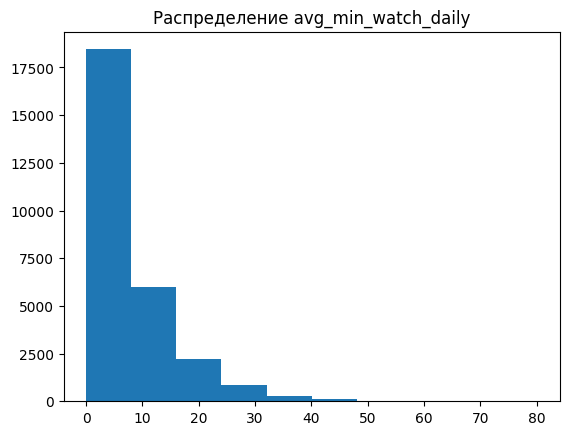

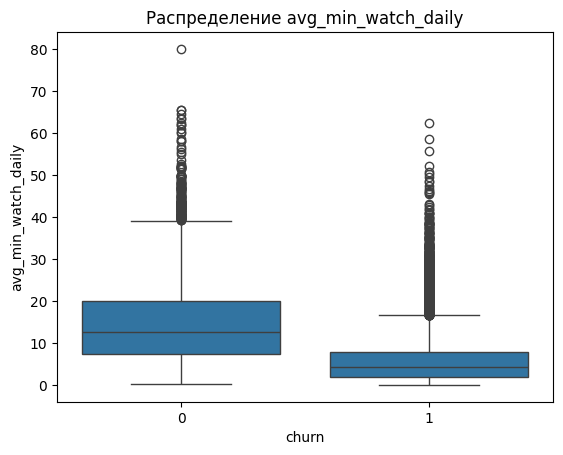

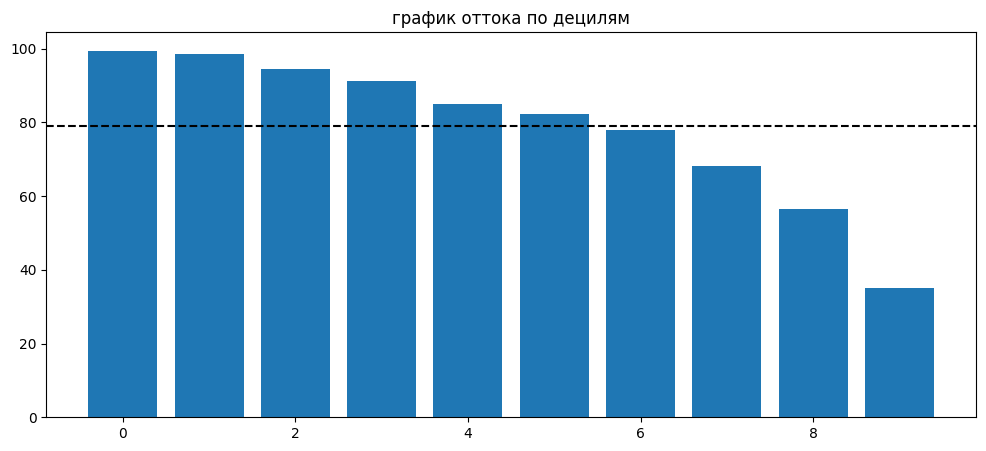

Децили и абсолютные значения


,churn_rate,time_min,time_max,time_mean,time_range
time_decile,,,,,
0,0.995000,0.000181,0.898715,0.444473,0-1
1,0.987143,0.898942,1.957453,1.409692,1-2
2,0.945714,1.957459,3.084868,2.522268,2-3
3,0.913214,3.085124,4.237532,3.666212,3-4
4,0.850714,4.237720,5.418555,4.820555,4-5
5,0.822143,5.419469,6.877299,6.104258,5-7
6,0.779643,6.877854,8.996087,7.852154,7-9
7,0.681786,8.996249,12.339487,10.561283,9-12
8,0.566071,12.339936,18.095801,14.845867,12-18


In [6]:
# Смотрим распределение avg_min_watch_daily
plt.hist(df['avg_min_watch_daily'])
plt.title('Распределение avg_min_watch_daily')
plt.show()

sns.boxplot(x='churn', y='avg_min_watch_daily', data=df)
plt.title('Распределение avg_min_watch_daily')
plt.show()

# Построим график churn'a по децилям avg_min_watch_daily

# 1. Разбиваем на 10 групп по времени просмотра
df['time_decile'] = pd.qcut(df['avg_min_watch_daily'], q=10, labels=False, duplicates='drop')

# 2. Считаем churn в каждой группе
decile_stats = df.groupby('time_decile').agg({
    'churn': 'mean',
    'avg_min_watch_daily': ['min', 'max', 'mean']
})

decile_stats.columns = ['churn_rate', 'time_min', 'time_max', 'time_mean']
decile_stats['time_range'] = [f'{row["time_min"]:.0f}-{row["time_max"]:.0f}' for _, row in decile_stats.iterrows()]

# график churn'a по децилям
plt.figure(figsize=(12, 5))

plt.bar(decile_stats.index, decile_stats['churn_rate'] * 100)
plt.axhline(y=df['churn'].mean() * 100, color='black', linestyle='--', label='Общий отток')
plt.title('график оттока по децилям')
plt.show()

print("Децили и абсолютные значения")
decile_stats.head(10)

* Из графиков видно, что распределение не нормальное, имеет длинный тяжелый хвост справа - это пригодится позднее для выбора стат. критерия проверки гипотезы.
* Из графика оттока по децилям видно, что отток достаточно резко падает на шестом-седьмом дециле. Для формирования гипотезы возьмем пороговое значение примерно в середине этого интервала - 10 минут.

### Гипотеза 1 
Пользователи, проводящие в приложении в среднем более 10 мин/день чаще конвертируются в подписку, чем те, кто проводят в среднем меньше 10 мин/день.

### Посмотрим на number_of_days_logged

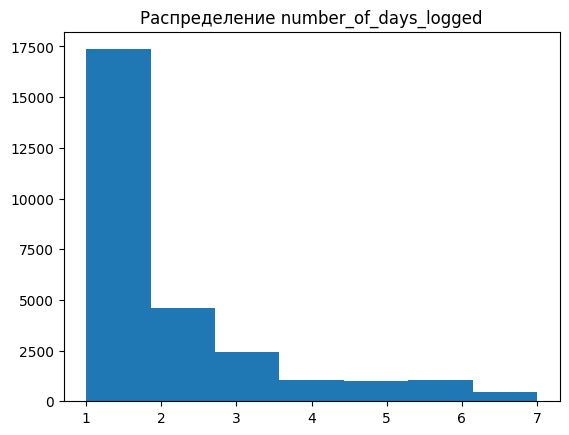

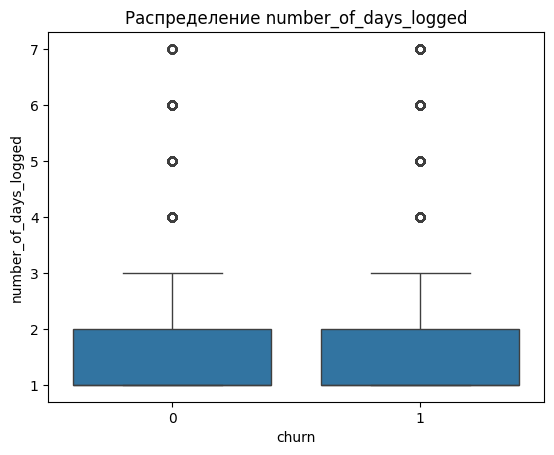

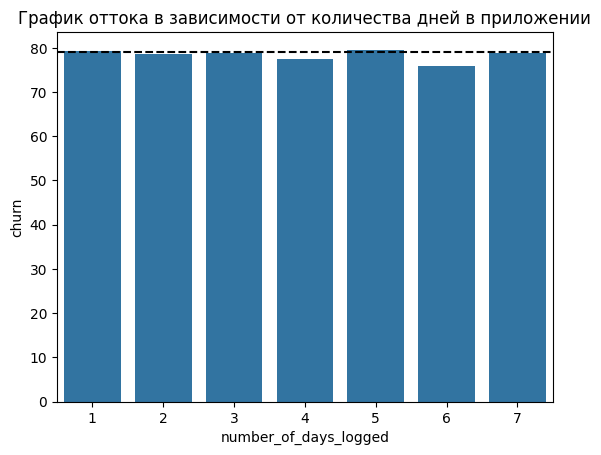

In [7]:
# Смотрим распределение avg_min_watch_daily
plt.hist(df['number_of_days_logged'], bins = 7)
plt.title('Распределение number_of_days_logged')
plt.show()

sns.boxplot(x='churn', y='number_of_days_logged', data=df)
plt.title('Распределение number_of_days_logged')
plt.show()

# Смотрим отток по дням
tmp = df.groupby('number_of_days_logged')[['churn']].mean().reset_index()
sns.barplot(data = tmp, x = 'number_of_days_logged', y = tmp['churn']*100)
plt.axhline(y=df['churn'].mean() * 100, color='black', linestyle='--', label='Общий отток')
plt.title("График оттока в зависимости от количества дней в приложении")
plt.show()

* Из графиков видно, что распределение не нормальное, имеет длинный тяжелый хвост справа - это пригодится позднее для выбора стат. критерия проверки гипотезы.
* Из графика оттока в зависимости от количества дней в приложении видно, что отток минимален при шести днях в приложении. Положим это в основу гипотезы.
### Гипотеза 2

Пользователи, которые провели в приложении 6 дней, чаще покупают подписку, чем все остальные пользователи.

### Посмотрим на city_Yekaterinburg

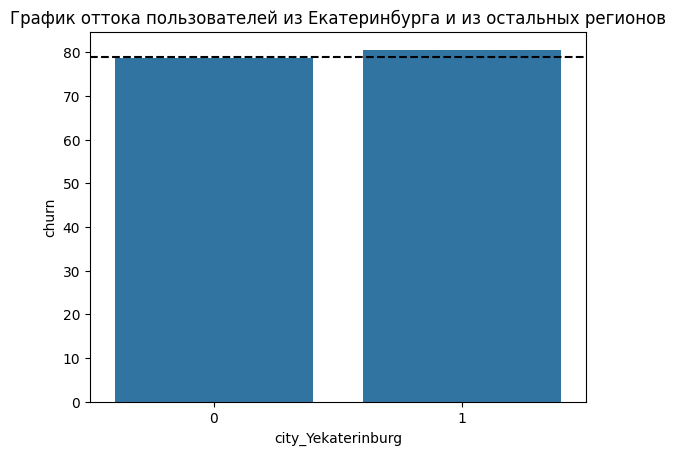

In [8]:
import matplotlib.pyplot as plt

tmp = df.groupby('city_Yekaterinburg')[['churn']].mean().reset_index()

sns.barplot(data = tmp, x = 'city_Yekaterinburg', y = tmp['churn']*100)
plt.axhline(y=df['churn'].mean() * 100, color='black', linestyle='--', label='Общий отток')
plt.title("График оттока пользователей из Екатеринбурга и из остальных регионов")
plt.show()

Из графика видно, что пользователи из Екатеринбурга больше подвержены оттоку, чем в среднем по выборке.

### Гипотеза 3
Пользователи из Екатеринбурга реже покупают подписку, чем пользователи из других городов. 

(Мы пытаемся ответить на вопрос "как сделать так, чтобы пользователи покупали подписку после триала", и если эта гипотеза подтвердится, это будет поводом для исследования, чем пользователи из Екатеринбурга так отличаются от остальных и как сделать так, чтобы для них отток уменьшился)

## Проверка гипотез по статистическими тестам
___

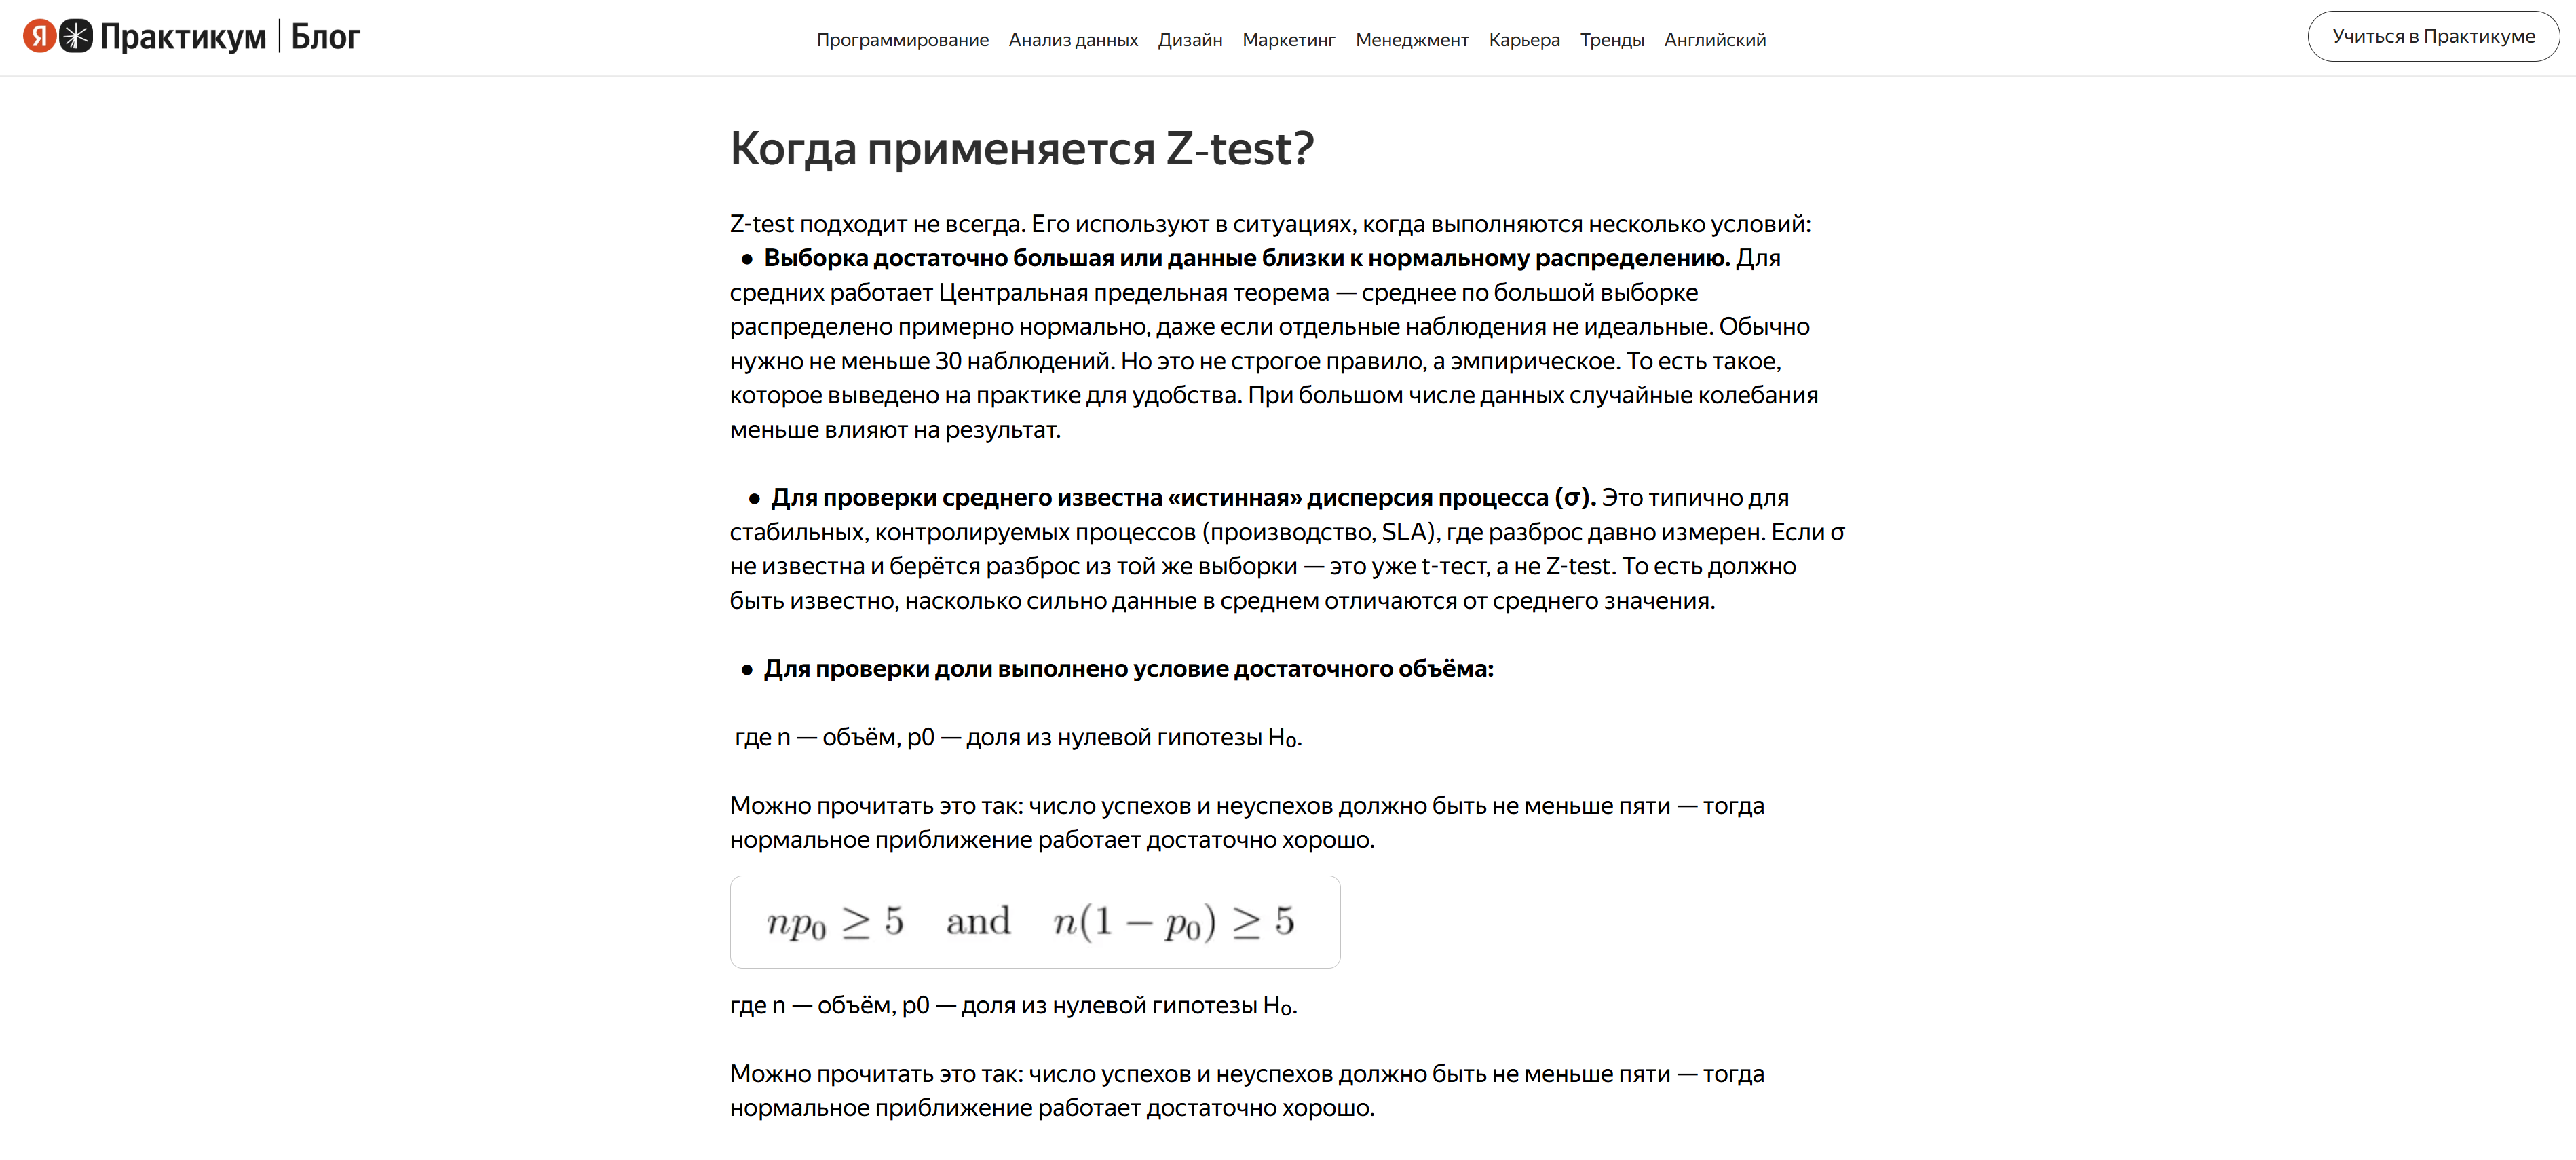

[Z-test: как его проводят и в чём отличие от T-test](https://practicum.yandex.ru/blog/z-test-proverka-gipotez/#kogda-primenyayetsya-z-test)

In [ ]:
import scipy.stats as sts
from statsmodels.stats.proportion import (proportions_ztest,
                                          proportion_confint,
                                          confint_proportions_2indep)

#### **Демонстрация Центральной предельной теоремы (ЦПТ)**

Мы взяли 10000 случайных выборок по 2000 пользователей и посчитали средний churn в каждой.

Результат: распределение средних приблизительно нормальное для churn (бинарная переменная).

Это обосновывает использование Z-теста для проверки гипотез о долях — при большом n выборочные средние распределены нормально.

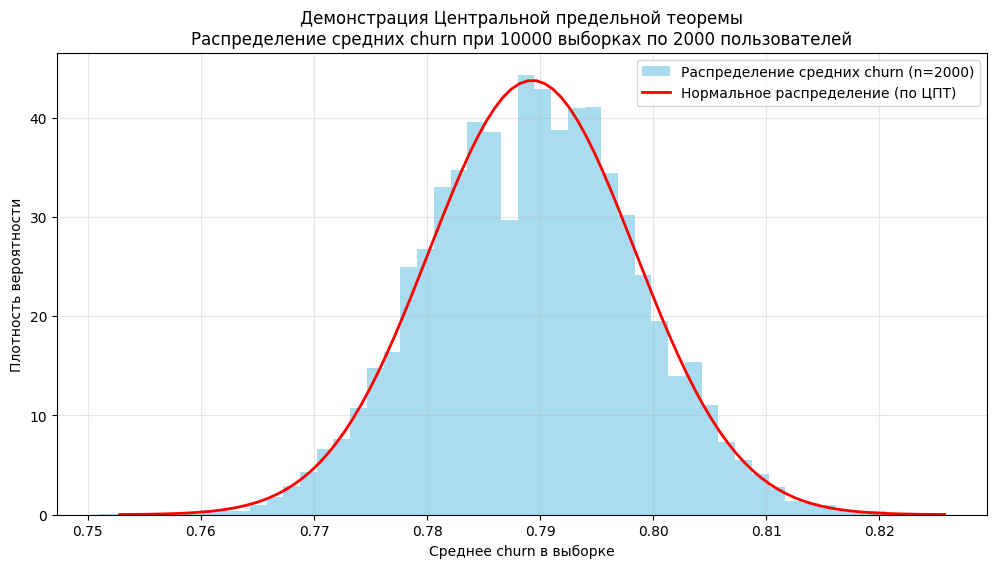

Генеральное среднее churn: 0.7893
Среднее распределения средних: 0.7893
Теоретическая стандартная ошибка: 0.0091
Реальная стандартная ошибка распределения: 0.0091


In [ ]:
# Проверка на Центральная предельная теорема
n_samples = 2000      # размер каждой выборки
n_iterations = 10000  # количество повторений

# Распределение средних churn из всей базы
mean_churn_list = []
for _ in range(n_iterations):
    sample_mean = df.sample(n=n_samples, replace=True)['churn'].mean()
    mean_churn_list.append(sample_mean)
    
# Гистограмма
plt.figure(figsize=(12, 6))
plt.hist(mean_churn_list,
         bins=50,
         density=True,
         alpha=0.7,
         color='skyblue',
         label='Распределение средних churn (n=2000)')

# Теоретическая нормальная кривая по ЦПТ
mu = df['churn'].mean()                     # генеральное среднее
sigma = df['churn'].std() / np.sqrt(n_samples)  # стандартная ошибка среднего
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x,
         norm.pdf(x, mu, sigma),
         'r-',
         lw=2,
         label='Нормальное распределение (по ЦПТ)')

plt.title('Демонстрация Центральной предельной теоремы\n' +
          'Распределение средних churn при 10000 выборках по 2000 пользователей')
plt.xlabel('Среднее churn в выборке')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Статистика
print(f"Генеральное среднее churn: {mu:.4f}")
print(f"Среднее распределения средних: {np.mean(mean_churn_list):.4f}")
print(f"Теоретическая стандартная ошибка: {sigma:.4f}")
print(f"Реальная стандартная ошибка распределения: {np.std(mean_churn_list):.4f}")

### Гипотеза 1

###
___
  * **H0 (нулевая)**: пользователи, проводящие в приложении в среднем >= 10 мин/день **покупают подписку не чаще**, чем остальные
  * **H1 (альтернативная)**: пользователи, проводящие в приложении в среднем  10 мин/день **покупают подписку чаще**, чем остальные.
___
Проверка гипотезы


In [11]:
# Формирование целевой выборки из генеральной совокупности

sample1 = pd.DataFrame({
    'group': np.where(
        df['avg_min_watch_daily'] >= 10.,
        'sample11', # >= 10 мин
        'sample12' # <= 10 мин
    ),
    'conversion': np.where(
        df['churn'] == 1, 0, 1 # 1 = купил, 0 = ушёл
    ),
})

sample1.value_counts().sort_index()


group     conversion
sample11  0              3795
          1              3663
sample12  0             18305
          1              2237
Name: count, dtype: int64

In [12]:
# Z-тест

successes = np.array([
    sample1[sample1['group'] == 'sample11']['conversion'].sum(),  # количество покупок в ≥10 мин
    sample1[sample1['group'] == 'sample12']['conversion'].sum()   # количество покупок в <10 мин
])

nobs = np.array([
    len(sample1[sample1['group'] == 'sample11']),  # размер группы ≥10 мин
    len(sample1[sample1['group'] == 'sample12'])   # размер группы <10 мин
])

# alternative='larger' — проверяем, что первая группа (sample11) имеет большую конверсию
zstat, pvalue = proportions_ztest(successes, nobs, alternative='larger')

print(f"p-value: {pvalue:.6f}")

p-value: 0.000000


**Визуализация**

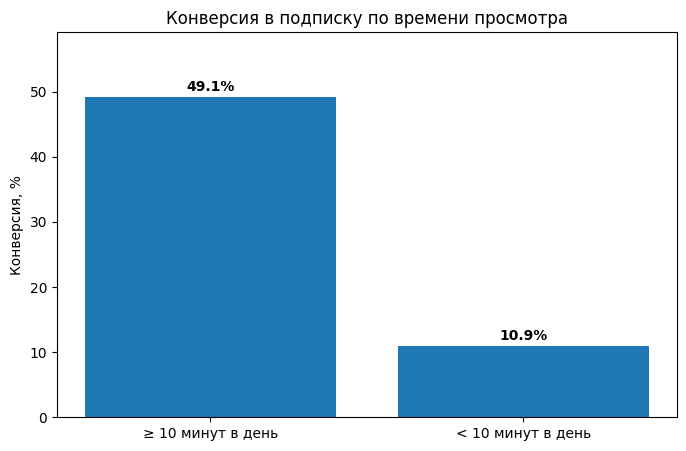

In [13]:
# Расчет доли конверсии
conv11 = sample1[sample1['group'] == 'sample11']['conversion'].mean() * 100
conv12 = sample1[sample1['group'] == 'sample12']['conversion'].mean() * 100

# Построение графика
plt.figure(figsize=(8, 5))
plt.bar(['≥ 10 минут в день', '< 10 минут в день'], [conv11, conv12])
plt.title('Конверсия в подписку по времени просмотра')
plt.ylabel('Конверсия, %')
plt.ylim(0, max(conv11, conv12) + 10)
plt.text(0, conv11 + 1, f'{conv11:.1f}%', ha='center', fontweight='bold')
plt.text(1, conv12 + 1, f'{conv12:.1f}%', ha='center', fontweight='bold')

plt.show()

### Вывод по гипотезе 1

Z-тест показал очень маленькое **p-value** (практически 0).

Это значит, что пользователи, которые смотрят **≥ 10 минут в день**, значительно чаще покупают подписку, чем остальные.

`Гипотеза подтверждается`

### Гипотеза 2

###
___
  * **H0 (нулевая)**: пользователи, которые логинились в приложении 6 дней, покупают подписку **не чаще**, чем все остальные пользователи.
  * **H1 (альтернативная)**: пользователи, которые логинились в приложении 6 дней, **чаще покупают подписку**, чем все остальные пользователи.

___
Проверка гипотезы


In [14]:
# Формирование целевой выборки из генеральной совокупности

sample2 = pd.DataFrame({
    'group': np.where(
        df['number_of_days_logged'] == 6,
        'sample21', # пользователи, которые заходили ровно 6 дней
        'sample22' # остальные пользователи
    ),
    'conversion': np.where(
        df['churn'] == 1, 0, 1 # 1 = купил, 0 = ушёл
    ),
})

sample2.value_counts().sort_index()


group     conversion
sample21  0               806
          1               258
sample22  0             21294
          1              5642
Name: count, dtype: int64

In [15]:
#Z-тест
sample21 = sample2[sample2['group'] == 'sample21']
sample22 = sample2[sample2['group'] == 'sample22']

# Число покупок
successes = np.array([
    sample21['conversion'].sum(),
    sample22['conversion'].sum()
])

# Размеры выборок
nobs = np.array([
    len(sample21),
    len(sample22)
])

# Односторонний z-тест
zstat, pvalue = proportions_ztest(
    successes,
    nobs,
    alternative='larger'
)

print(f"p-value: {pvalue:.6f}")

p-value: 0.004791


#### Визуализация

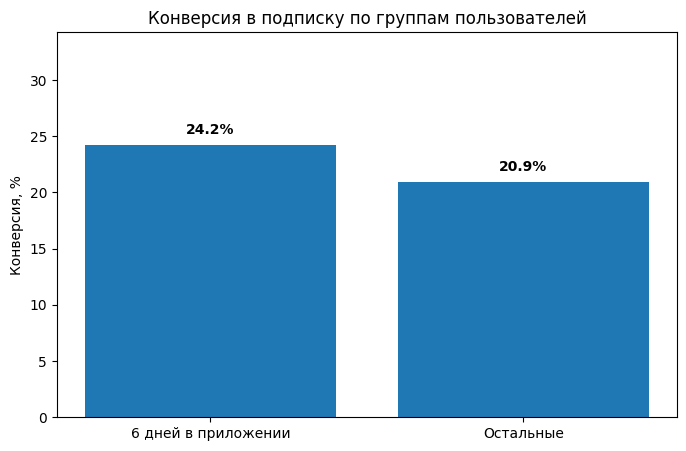

In [16]:
# Расчет конверсии в процентах
conv21 = sample21['conversion'].mean() * 100
conv22 = sample22['conversion'].mean() * 100

# Построение графика
plt.figure(figsize=(8, 5))
plt.bar(['6 дней в приложении', 'Остальные'], [conv21, conv22])
plt.title('Конверсия в подписку по группам пользователей')
plt.ylabel('Конверсия, %')
plt.ylim(0, max(conv21, conv22) + 10)
plt.text(0, conv21 + 1, f'{conv21:.1f}%', ha='center', fontweight='bold')
plt.text(1, conv22 + 1, f'{conv22:.1f}%', ha='center', fontweight='bold')

plt.show()


### Вывод по гипотезе 2

Z-тест показал статистически значимую разницу (p-value < 0.05).

`Разница практически значима`

### Гипотеза 3

###
___    
**H0 (нулевая)**: Доля пользователей, купивших подписку, среди жителей Екатеринбурга **равна** доле среди пользователей из других городов.

**H1 (альтернативная)**: Доля пользователей, купивших подписку, среди жителей Екатеринбурга **ниже**, чем среди пользователей из других городов.

(Если гипотеза подтвердится, это станет поводом для исследования причин низкой конверсии в Екатеринбурге и разработки мер для снижения оттока в этом сегменте.)             

___
Проверка гипотезы


In [17]:
# Формирование целевой выборки из генеральной совокупности

sample3 = pd.DataFrame({
    'group': np.where(
        df['city_Yekaterinburg'] == 1,
        'sample31', # Екатеринбург
        'sample32' # Остальные города
    ),
    'conversion': np.where(
        df['churn'] == 1, 0, 1  # 1 = купил, 0 = ушёл
    ),
})

sample3.value_counts().sort_index()


group     conversion
sample31  0              1558
          1               374
sample32  0             20542
          1              5526
Name: count, dtype: int64

In [18]:
# Z-тест
successes = np.array([
    sample3[sample3['group'] == 'sample31']['conversion'].sum(),  # Екатеринбург
    sample3[sample3['group'] == 'sample32']['conversion'].sum()   # Остальные города
])
nobs = np.array([
    len(sample1[sample3['group'] == 'sample31']),  # Екатеринбург
    len(sample1[sample3['group'] == 'sample32'])   # Остальные города
])

# alternative='smaller' — проверяем, что первая группа (sample31) имеет меньшую конверсию
zstat, pvalue = proportions_ztest(successes, nobs, alternative='smaller')

print(f"p-value: {pvalue:.6f}")

p-value: 0.027826


#### Визуализация

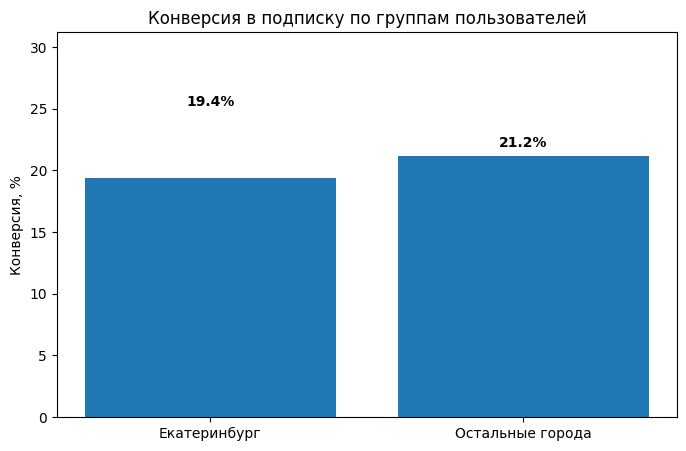

In [19]:
# Рассчитываем конверсии в процентах
conv31 = sample3[sample3['group'] == 'sample31']['conversion'].mean() * 100
conv32 = sample3[sample3['group'] == 'sample32']['conversion'].mean() * 100

# Построение графика
plt.figure(figsize=(8, 5))
plt.bar(['Екатеринбург', 'Остальные города'], [conv31, conv32])
plt.title('Конверсия в подписку по группам пользователей')
plt.ylabel('Конверсия, %')
plt.ylim(0, max(conv31, conv32) + 10)
plt.text(0, conv21 + 1, f'{conv31:.1f}%', ha='center', fontweight='bold')
plt.text(1, conv22 + 1, f'{conv32:.1f}%', ha='center', fontweight='bold')
plt.show()

### Вывод по гипотезе 3

Z-тест показал **p-value ≈ 0.028** < 0.05.

Это означает, что разница в конверсии между группами **статистически значима** на уровне 5%.

`Гипотеза подтверждается`
